In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
"""
 The Zillow csv provides ZHVI for neighborhoods in the US.
 Zillow Home Value Index (ZHVI): A measure of the typical home value and market changes across a given region and housing type. 
 It reflects the typical value for homes in the 35th to 65th percentile range.
 More info about ZHVI: https://www.zillow.com/research/methodology-neural-zhvi-32128/
"""

df = pd.read_csv('Neighborhood_zillow.csv')
print("shape:", df.shape)

In [ ]:
# print columns
print("Columns:")
print(df.columns.to_list())

chicago_df = df[df['City'] == "Chicago"]

# Different neighborhoods
print()
print("Chicago neighborhoods:")
print(chicago_df['RegionName'].unique()[:15])

# isolate Little Italy
print()
little_italy = chicago_df[chicago_df['RegionName'] == 'University Village - Little Italy']
print("Little Italy 2000-01", little_italy['2000-01-31'])
print("Little Italy 2024-09", little_italy['2024-09-30'])


In [ ]:
# Filter regions into different dataframes based on classification

# North Side
north_side_regions = [
    'Rogers Park', 'Edgewater', 'Uptown', 'Lake View', 'Lincoln Park', 
    'North Center', 'Lincoln Square', 'West Ridge', 'Irving Park', 
    'Albany Park', 'Avondale'
]
north_side_df = chicago_df[chicago_df['RegionName'].isin(north_side_regions)]

# South Side
south_side_regions = [
    'Armour Square', 'Bridgeport', 'Brighton Park', 'New City (Back of the Yards)', 
    'Englewood', 'Greater Grand Crossing', 'Hyde Park', 'Kenwood', 'Oakland', 
    'South Shore', 'Washington Park', 'Woodlawn', 'Chatham', 'South Chicago', 
    'Auburn Gresham', 'Calumet Heights', 'Roseland', 'Pullman', 'West Pullman', 
    'Riverdale'
]
south_side_df = chicago_df[chicago_df['RegionName'].isin(south_side_regions)]

# East Side
east_side_regions = ['Hegewisch', 'East Side', 'South Shore', 'Hyde Park', 'Kenwood']
east_side_df = chicago_df[chicago_df['RegionName'].isin(east_side_regions)]

# West Side
west_side_regions = [
    'Austin', 'East Garfield Park', 'West Garfield Park', 'North Lawndale', 
    'South Lawndale (Little Village)', 'Humboldt Park', 'Near West Side', 'West Town'
]
west_side_df = chicago_df[chicago_df['RegionName'].isin(west_side_regions)]

# Northwest Side
northwest_side_regions = [
    'Jefferson Park', 'Portage Park', 'Norwood Park', 'Dunning', 'Belmont Cragin', 
    'Montclare', 'Irving Park', 'Hermosa'
]
northwest_side_df = chicago_df[chicago_df['RegionName'].isin(northwest_side_regions)]

# Southwest Side
southwest_side_regions = [
    'Garfield Ridge', 'Archer Heights', 'Brighton Park', 'Gage Park', 'West Elsdon', 
    'West Lawn', 'Chicago Lawn (Marquette Park)', 'Ashburn', 'Clearing'
]
southwest_side_df = chicago_df[chicago_df['RegionName'].isin(southwest_side_regions)]

print("North Side neighborhoods: \n", north_side_df.head())
print("South Side neighborhoods: \n", south_side_df.head())
print("East Side neighborhoods: \n", east_side_df.head())
print("West Side neighborhoods: \n", west_side_df.head())
print("Northwest Side neighborhoods: \n", northwest_side_df.head())
print("Southwest Side neighborhoods: \n", southwest_side_df.head())

In [ ]:
# Unpivot date columns so data is more rectangular
def reshape_dates(df):
    # Identify date columns 
    date_columns = [col for col in df.columns if col.startswith('20')]
    
    # Melt dataframe to convert date columns into rows
    df_melted = df.melt(id_vars=['RegionID', 'SizeRank', 'RegionName'],
                        value_vars=date_columns,
                        var_name='Date', value_name='ZHVI')
    
    # Convert Date to datetime fromat
    df_melted['Date'] = pd.to_datetime(df_melted['Date'])

    return df_melted

reshaped_df = reshape_dates(chicago_df)
reshaped_df.head()

In [ ]:
# Filter for Lake View
lake_view_df = reshaped_df[reshaped_df['RegionName'] == 'Lake View']

# Plot ZHVI over time for Lake View
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='ZHVI', data=lake_view_df)
plt.title("ZHVI Value Over Time for Lake View")
plt.xlabel("Date")
plt.ylabel("ZHVI")
plt.show()

In [ ]:
pd.read_csv('Chicago_ZIP_Populations_2010.csv')

In [ ]:
# Clean up populations csv's
def clean_population(year):
    filename = 'Chicago_ZIP_Populations_' + str(year) + '.csv'
    df = pd.read_csv(filename)

    # Transpose columns and rows
    df = df.set_index('Label (Grouping)').transpose().reset_index()

    # Rename columns
    df.columns = ['Zip Code', 'Total']

    # Remove prefix from Zip codes
    df['Zip Code'] = df['Zip Code'].str[6:]
    df['Year'] = year
    
    return df

pop_2010 = clean_population(2010)
pop_2020 = clean_population(2020)

# Combine both years into one dataframe
population_df = pd.concat([pop_2010, pop_2020], ignore_index=True)

population_df

In [ ]:
# north side 

reshaped_north_side_df = reshape_dates(north_side_df)

# Plot ZHVI over time for Lake View
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='ZHVI', data=reshaped_north_side_df)
plt.title("ZHVI Value Over Time for North Side")
plt.xlabel("Date")
plt.ylabel("ZHVI")
plt.show()

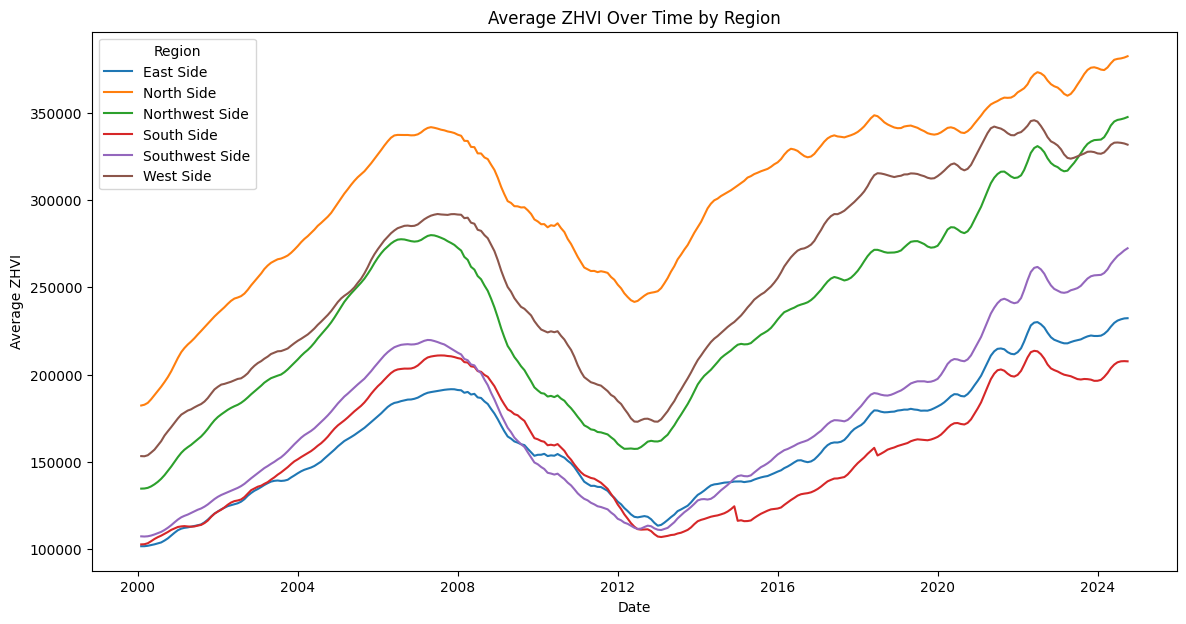

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume previous imports and data loading have been done

# Create region mapping
region_mapping = {}

# North Side
for neighborhood in north_side_regions:
    region_mapping[neighborhood] = 'North Side'

# South Side
for neighborhood in south_side_regions:
    region_mapping[neighborhood] = 'South Side'

# East Side
for neighborhood in east_side_regions:
    region_mapping[neighborhood] = 'East Side'

# West Side
for neighborhood in west_side_regions:
    region_mapping[neighborhood] = 'West Side'

# Northwest Side
for neighborhood in northwest_side_regions:
    region_mapping[neighborhood] = 'Northwest Side'

# Southwest Side
for neighborhood in southwest_side_regions:
    region_mapping[neighborhood] = 'Southwest Side'

# Add 'Region' column to reshaped_df
reshaped_df['Region'] = reshaped_df['RegionName'].map(region_mapping)

# Filter out rows where 'Region' is NaN
reshaped_df = reshaped_df[~reshaped_df['Region'].isna()]

# Group by 'Date' and 'Region' and compute average ZHVI
grouped = reshaped_df.groupby(['Date', 'Region'])['ZHVI'].mean().reset_index()

# Plot average ZHVI over time for each region
plt.figure(figsize=(14, 7))
sns.lineplot(data=grouped, x='Date', y='ZHVI', hue='Region')
plt.title('Average ZHVI Over Time by Region')
plt.xlabel('Date')
plt.ylabel('Average ZHVI')
plt.legend(title='Region')
plt.show()
